<a href="https://colab.research.google.com/github/sinitsky96/Time-Series-Project/blob/main/prophet_checks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import plot_components
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from datetime import datetime

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

# Suppress specific statsmodels warnings about frequency
warnings.filterwarnings('ignore', 'No frequency information was provided')
warnings.filterwarnings('ignore', 'No supported index is available')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [63]:
import logging
logging.getLogger("cmdstanpy").disabled = True

In [3]:
from google.colab import files
uploaded = files.upload()

Saving co_half_monthly.csv to co_half_monthly.csv


In [40]:
co = pd.read_csv('co_half_monthly.csv', parse_dates=['date'])
co.set_index('date', inplace=True)
co = co[co.index >= '2012-01-01']

df = (co.groupby(co.index)["CO"]
      .mean()
      .reset_index()
      .set_index('date'))

In [41]:
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (253, 1)
Test shape: (64, 1)


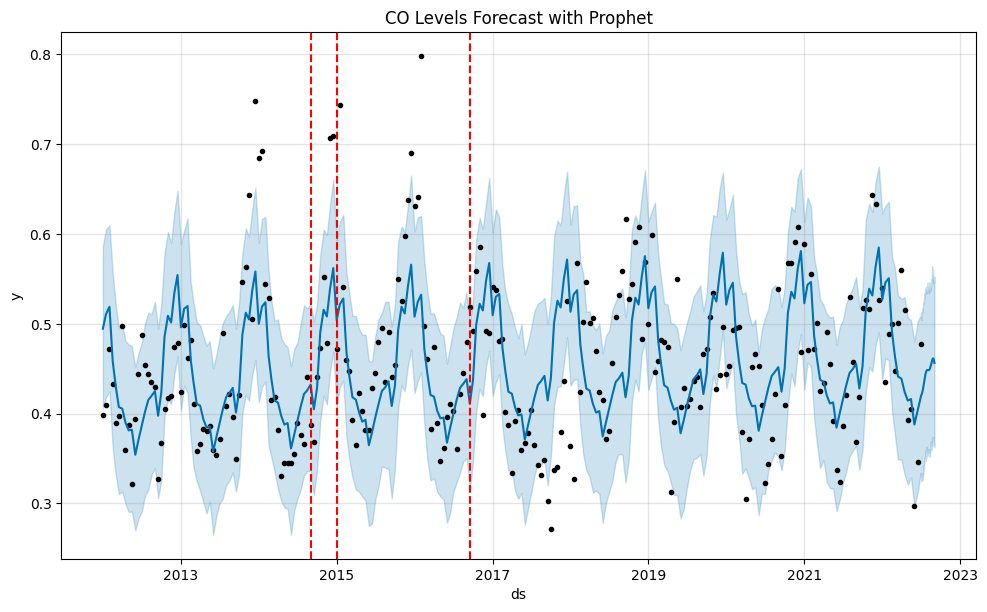

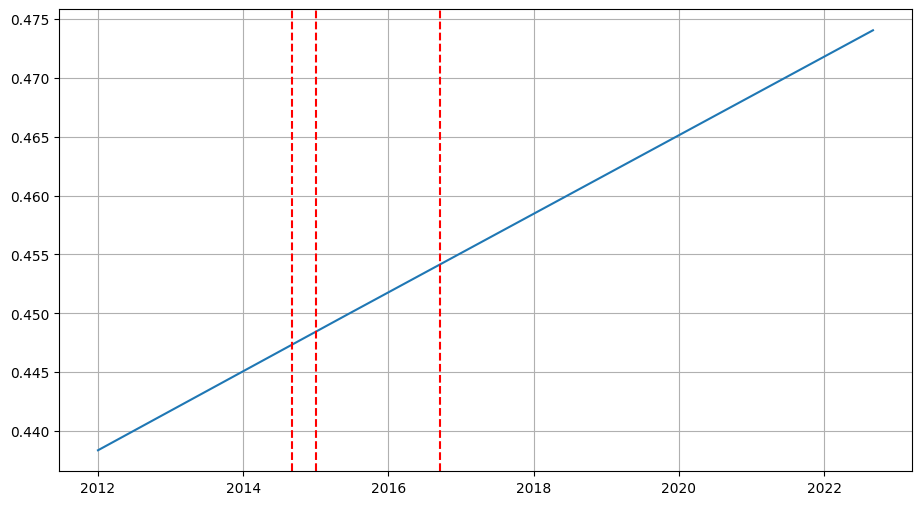

In [59]:
# Convert the training data to Prophet format
prophet_df = train.reset_index()
prophet_df.columns = ['ds', 'y']  # Prophet requires these specific column names

# Fit Prophet model on training data
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False,
                        daily_seasonality=False, changepoint_prior_scale=0.01)

model_prophet.fit(prophet_df)

changpoints = pd.DataFrame({"cp": model_prophet.changepoints,
             "deltas" : np.abs(model_prophet.params['delta'])[0]
             })

top_n = 3
top_cp = changpoints.sort_values(by='deltas', ascending=False).head(top_n)['cp']

# Forecast for a number of periods equal to the length of the test set
future_dates = model_prophet.make_future_dataframe(periods=len(test))
forecast_prophet = model_prophet.predict(future_dates)

# Calculate metrics for both models
prophet_fitted = forecast_prophet.loc[forecast_prophet['ds'].isin(prophet_df['ds']), 'yhat']
prophet_actual = prophet_df['y']


prophet_metrics = {
    'RMSE': np.sqrt(mean_squared_error(prophet_actual, prophet_fitted)),
    'MAE': mean_absolute_error(prophet_actual, prophet_fitted)
}

# Plot Prophet forecast and components
fig1 = model_prophet.plot(forecast_prophet)
for cp in top_cp:
    plt.axvline(x=cp, color='r', linestyle='--')
plt.title('CO Levels Forecast with Prophet')
plt.show()

plt.figure(figsize=(11, 6))
# fig2 = model_prophet.plot_components(forecast_prophet)
plt.plot(forecast_prophet['ds'], forecast_prophet['trend'])
for cp in top_cp:
    plt.axvline(x=cp, color='r', linestyle='--')
plt.grid()
plt.show()

In [ ]:
#  Define a Range of changepoint_prior_scale Values to Compare
cps_values = [0.001, 0.01, 0.05, 0.1, 0.5]

# Collect performance metrics for each CPS value
all_perf = []

for cps in cps_values:
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=cps
    )
    model.fit(prophet_df)

    # Cross-Validation Setup
    df_cv = cross_validation(
        model=model,
        initial='1460 days',  # ~4 years
        period='180 days',    # ~6 months
        horizon='365 days',   # ~1 year forecast
        parallel='processes'  # speeds up CV if you have multiple CPUs
    )

   # Compute Performance Metrics
    df_perf = performance_metrics(df_cv)
    df_perf['changepoint_prior_scale'] = cps

    all_perf.append(df_perf)

INFO:prophet:Making 12 forecasts with cutoffs between 2016-01-29 00:00:00 and 2021-07-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7df59eb4e550>
INFO:prophet:Making 12 forecasts with cutoffs between 2016-01-29 00:00:00 and 2021-07-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7df59de5a190>
INFO:prophet:Making 12 forecasts with cutoffs between 2016-01-29 00:00:00 and 2021-07-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7df59dcee250>
INFO:prophet:Making 12 forecasts with cutoffs between 2016-01-29 00:00:00 and 2021-07-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7df59ddb3590>
INFO:prophet:Making 12 forecasts with cutoffs between 2016-01-29 00:00:00 and 2021-07-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures

In [61]:
results_df = pd.concat(all_perf, ignore_index=True)
print(results_df)

     horizon       mse      rmse       mae      mape     mdape     smape  \
0    36 days  0.007741  0.087985  0.067081  0.146689  0.102199  0.135388   
1    37 days  0.007088  0.084192  0.065509  0.147687  0.102199  0.135157   
2    39 days  0.006358  0.079736  0.063293  0.146220  0.104674  0.132767   
3    41 days  0.006688  0.081781  0.065088  0.152418  0.104674  0.137698   
4    42 days  0.005893  0.076767  0.062036  0.145010  0.104674  0.133070   
..       ...       ...       ...       ...       ...       ...       ...   
985 359 days  0.015796  0.125681  0.099526  0.223331  0.175145  0.212246   
986 360 days  0.015808  0.125730  0.099643  0.224336  0.175145  0.213860   
987 363 days  0.018878  0.137397  0.109332  0.240325  0.183348  0.235523   
988 364 days  0.018488  0.135971  0.105944  0.233131  0.183348  0.227388   
989 365 days  0.018783  0.137049  0.108747  0.238588  0.191500  0.233547   

     coverage  changepoint_prior_scale  
0    0.714286                    0.001  
1    

In [62]:
results_df[results_df['horizon'] == '365 days']

,horizon,mse,rmse,mae,mape,mdape,smape,coverage,changepoint_prior_scale
197,365 days,0.011924,0.109197,0.082968,0.205510,0.148029,0.174910,0.678571,0.001
395,365 days,0.009814,0.099067,0.073156,0.181078,0.121977,0.155750,0.714286,0.010
593,365 days,0.012014,0.109610,0.089858,0.212577,0.164398,0.194484,0.571429,0.050
791,365 days,0.013775,0.117366,0.100105,0.231657,0.194708,0.220090,0.500000,0.100
989,365 days,0.018783,0.137049,0.108747,0.238588,0.191500,0.233547,0.535714,0.500


In [53]:
results_df.groupby('changepoint_prior_scale', as_index=False).mean()

,changepoint_prior_scale,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0.001,203 days 17:05:27.272727272,0.009141,0.095120,0.075373,0.178581,0.138949,0.162474,0.663149
1,0.010,203 days 17:05:27.272727272,0.008440,0.091422,0.072986,0.169816,0.133330,0.159178,0.664683
2,0.050,203 days 17:05:27.272727272,0.011028,0.104346,0.082013,0.185890,0.149594,0.184245,0.602183
3,0.100,203 days 17:05:27.272727272,0.012337,0.110209,0.085335,0.190095,0.160774,0.195020,0.564484
4,0.500,203 days 17:05:27.272727272,0.015733,0.124273,0.096859,0.210429,0.170955,0.220855,0.525343


In [43]:
tuning_change_point = [0.05, 0.1, 0.2, 0.5]
RMSE = []
MAE = []
MAPE  = []
for param in tuning_change_point:
  model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False,
                        daily_seasonality=False, changepoint_prior_scale=param)
  model_prophet.fit(prophet_df)
  future_dates = model_prophet.make_future_dataframe(periods=len(test))
  forecast_prophet = model_prophet.predict(future_dates)
  prophet_fitted = forecast_prophet.loc[forecast_prophet['ds'].isin(prophet_df['ds']), 'yhat']
  prophet_actual = prophet_df['y']
  RMSE.append(np.sqrt(mean_squared_error(prophet_actual, prophet_fitted)))
  MAE.append(mean_absolute_error(prophet_actual, prophet_fitted))
  MAPE.append(mean_absolute_percentage_error(prophet_actual, prophet_fitted))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpugnmsve8/ri54ng0g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpugnmsve8/20tzw4at.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57115', 'data', 'file=/tmp/tmpugnmsve8/ri54ng0g.json', 'init=/tmp/tmpugnmsve8/20tzw4at.json', 'output', 'file=/tmp/tmpugnmsve8/prophet_model2s9gag_h/prophet_model-20250327094417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:44:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:44:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpugnmsve8/2tau7dqs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpugnmsve8/bdfcv6hy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [45]:
pd.DataFrame({'RMSE': RMSE, 'MAE': MAE, 'MAPE': MAPE}, index=tuning_change_point)

,RMSE,MAE,MAPE
0.05,0.071230,0.054771,0.121502
0.10,0.070364,0.054154,0.120251
0.20,0.069009,0.054001,0.119960
0.50,0.064122,0.050957,0.112808


In [7]:
models = []
forecasts = []
for station in co.station.unique():
  df = co.loc[co['station'] == station].drop(['station'], axis = 1)
  train_size = int(len(df) * 0.8)
  train = df.iloc[:train_size]
  test = df.iloc[train_size:]

  prophet_df = train.reset_index()
  prophet_df.columns = ['ds', 'y']

  # Fit Prophet model on training data
  model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
  model_prophet.fit(prophet_df)

  models.append(model_prophet)

  # Forecast for a number of periods equal to the length of the test set
  future_dates = model_prophet.make_future_dataframe(periods=len(test))
  forecast_prophet = model_prophet.predict(future_dates)
  forecasts.append(forecast_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpugnmsve8/r84xoho9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpugnmsve8/jj7icz4r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83484', 'data', 'file=/tmp/tmpugnmsve8/r84xoho9.json', 'init=/tmp/tmpugnmsve8/jj7icz4r.json', 'output', 'file=/tmp/tmpugnmsve8/prophet_model1pb1j0wv/prophet_model-20250327084937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:49:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:49:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpugnmsve8/wl2a68kr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpugnmsve8/dpv7jd9t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

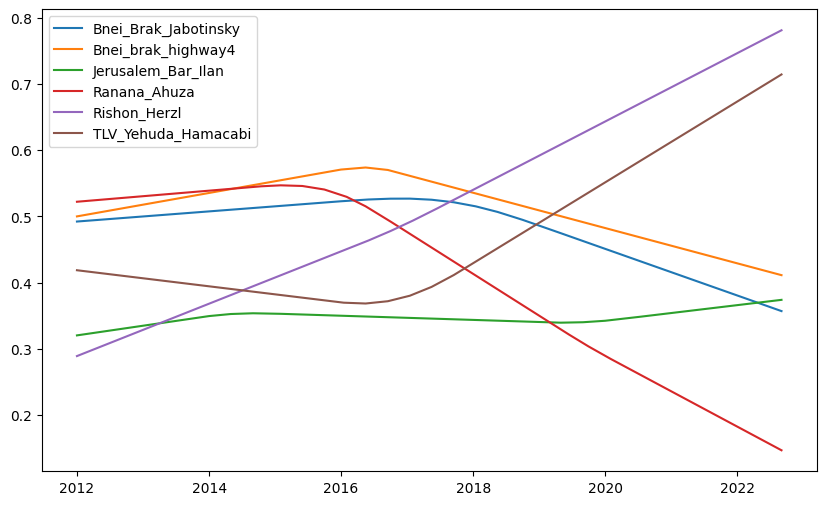

In [ ]:
plt.figure(figsize=(10, 6))
# prophet for each station:
for i in range(len(forecasts)):
  plt.plot(forecasts[i]['ds'], forecasts[i]['trend'],
           label=co.station.unique()[i])

plt.legend()



In [ ]:
future = pd.date_range(start='2022-01-01', end='2022-12-31')
df_future = pd.DataFrame({'ds': future})

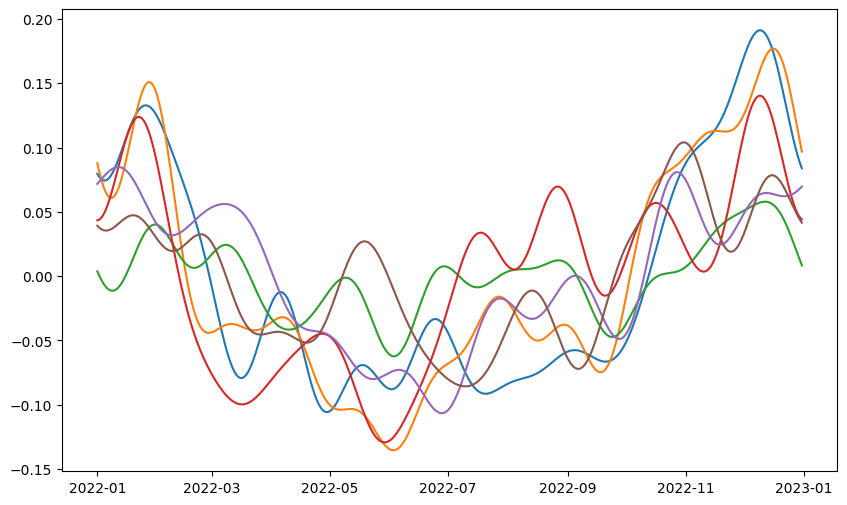

In [ ]:
plt.figure(figsize=(10, 6))
# prophet for each station:
for i in range(len(forecasts)):
  seasonal = models[i].predict_seasonal_components(df_future)
  plt.plot(df_future['ds'], seasonal['yearly'],
           label=co.station.unique()[i])


In [29]:
from google.colab import files
uploaded = files.upload()

Saving co_clean.csv to co_clean.csv


In [30]:
daily_co = pd.read_csv('co_clean.csv', parse_dates=['date_time'])
daily_co.set_index('date_time', inplace=True)
daily_co = daily_co[daily_co.index >= '2012-01-01']

daily_co_avg = (daily_co.groupby(daily_co.index)["co"]
      .mean()
      .reset_index()
      .set_index('date_time'))

In [31]:
train_size = int(len(daily_co_avg) * 0.8)
train = daily_co_avg.iloc[:train_size]
test = daily_co_avg.iloc[train_size:]
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (3847, 1)
Test shape: (962, 1)


In [ ]:
train.tail()

,CO
date,
2022-05-01,0.393098
2022-05-16,0.404702
2022-06-01,0.296825
2022-06-16,0.346349
2022-07-01,0.477302


DEBUG:cmdstanpy:input tempfile: /tmp/tmpugnmsve8/lrevbnlm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpugnmsve8/ecy888ml.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50700', 'data', 'file=/tmp/tmpugnmsve8/lrevbnlm.json', 'init=/tmp/tmpugnmsve8/ecy888ml.json', 'output', 'file=/tmp/tmpugnmsve8/prophet_model1s6outph/prophet_model-20250327090546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:05:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:05:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


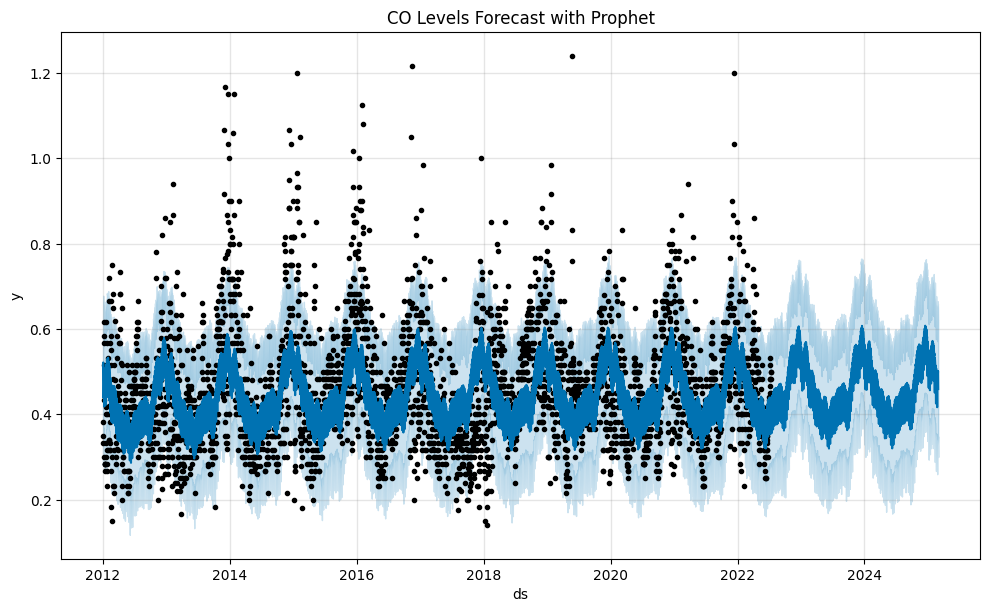

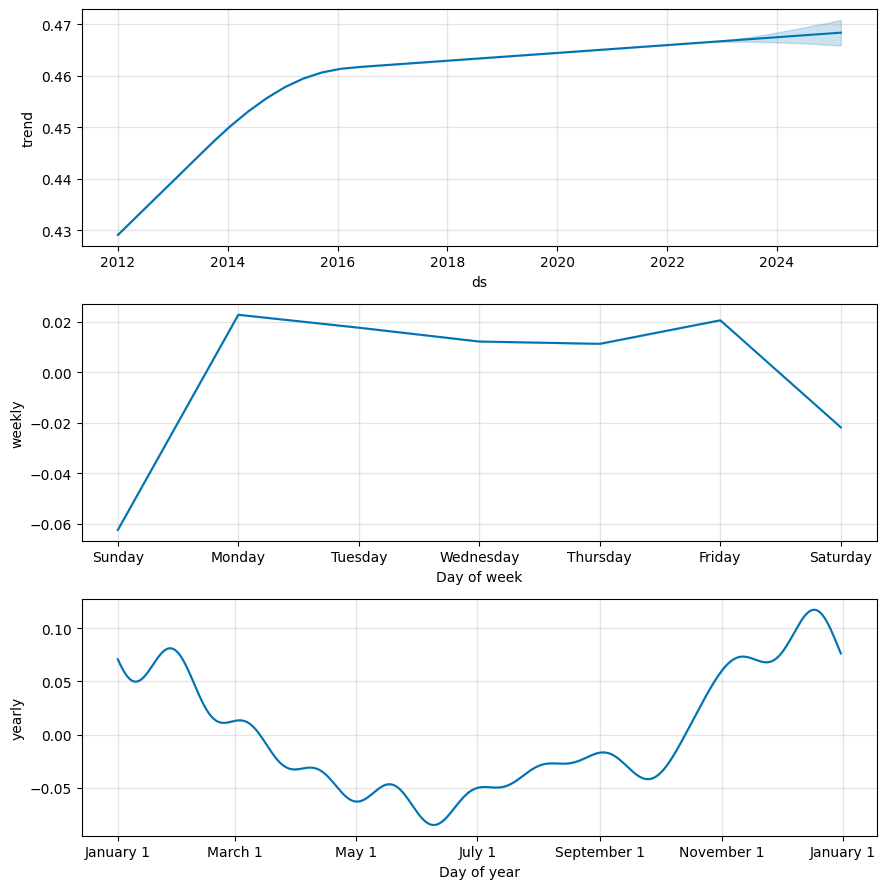

In [34]:
prophet_df = train.reset_index()
prophet_df.columns = ['ds', 'y']  # Prophet requires these specific column names

# Fit Prophet model on training data
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True,
                        daily_seasonality=False, changepoint_prior_scale=0.01)
model_prophet.fit(prophet_df)

# Forecast for a number of periods equal to the length of the test set
future_dates = model_prophet.make_future_dataframe(periods=len(test))
forecast_prophet = model_prophet.predict(future_dates)

# Calculate metrics for both models
prophet_fitted = forecast_prophet.loc[forecast_prophet['ds'].isin(prophet_df['ds']), 'yhat']
prophet_actual = prophet_df['y']


prophet_metrics = {
    'RMSE': np.sqrt(mean_squared_error(prophet_actual, prophet_fitted)),
    'MAE': mean_absolute_error(prophet_actual, prophet_fitted)
}

# Plot Prophet forecast and components
fig1 = model_prophet.plot(forecast_prophet)
plt.title('CO Levels Forecast with Prophet')
plt.show()

fig2 = model_prophet.plot_components(forecast_prophet)
plt.show()